# GEOG 650 GIS Programming and Automation, Liberty University

## **Guided Tour to Raster Geoprocessing with ArcPy**
## Tucker Hindle, GISP

Clone repository to download data: https://github.com/tuckerhindle/geog650-gis-programming/tree/main/mod5-image-processing-and-analysis

Description: drone-hyperspectral imaging of community farmland in southeast Florida collected by Tucker Hindle on 2024 October 27.

<img src="./assets/greenpepper_drone.png" width="700">

Figure 1. Green pepper farmland at 26° 29’ 08” N latitude, 80° 12’ 20” W longitude, and 13 feet elevation in Boynton Beach, Florida (left); Inspired Flight IF1200A remotely piloted aircraft system equipped with Resonon Pika XC2 hyperspectral imager (right).

<img src="./assets/studysite.png" width="700">

Figure 2. Study region in southeast Florida at a local green pepper farm (left); Drone flight path collecting hyperspectral data at 45 meters altitude and 1.5 meters per second ground speed. These data are captured by a line-scan hyperspectral imager at 1,600 spatial pixels per line and 231 spectral channels between 400nm to 1,000nm (right).

### Import ArcPy and Set Working Directory

In [1]:
import arcpy

In [2]:
arcpy.env.workspace = r'C:\Users\thindle2016\OneDrive - Liberty University\geog650\github\geog650-gis-programming\mod5-image-processing-and-analysis\data'
arcpy.env.overwriteOutput = True

### Load Raster

In [3]:
r = arcpy.Raster('fl_greenpepperfarm_hyperspectral_rgbn_20241027.tif')

### Explore Image Properties

In [4]:
# Coordinate System
r.spatialReference.name

'WGS_1984_UTM_Zone_17N'

In [5]:
# Columns
r.width

411

In [6]:
# Rows
r.height

1355

In [7]:
# Number of Bands
print(r.bandCount)

4


In [8]:
# Cell Size
print(f'{r.meanCellHeight:.3f} x {r.meanCellWidth:.3f}')
print(r.spatialReference.linearUnitName)

0.075 x 0.075
Meter


### Visualize Image and Band Combinations

The original hyperspectral data had 231 spectral channels; however, only four (4) are included in this image stack of red, green, blue, and near-infrared bands.

In [9]:
# Names of Spectral Channels
print(r.bandNames)

['Band_1', 'Band_2', 'Band_3', 'Band_4']


| Name | Description | Wavelength (nanometers) |
|----------|----------|----------|
| `Band_1` | Red | 648.7 nm |
| `Band_2` | Green | 550.7 nm |
| `Band_3` | Blue | 461.3 nm |
| `Band_4` | Near-infrared | 860.5 nm |

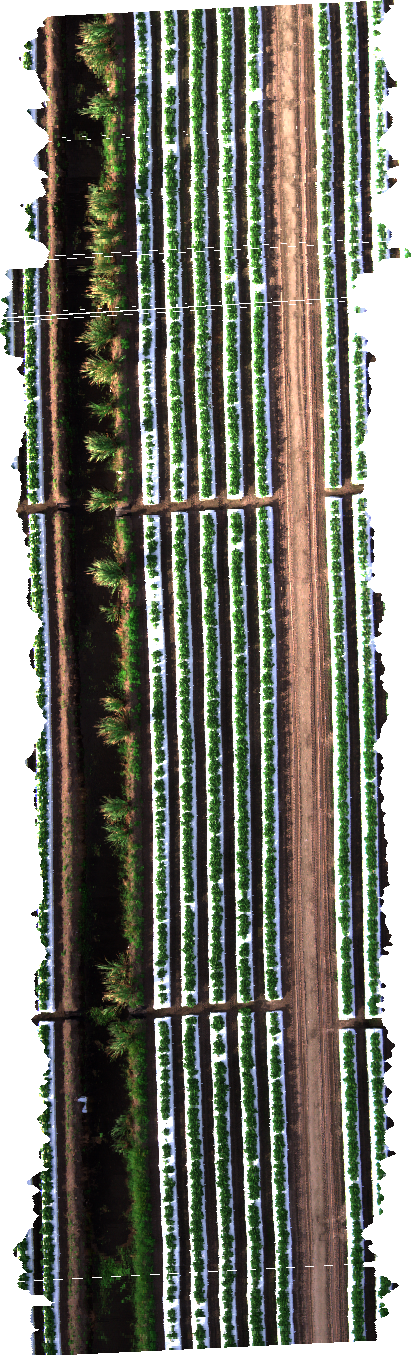

In [10]:
# Natural Color Image Composite
arcpy.Render(r, {'bands': [1, 2, 3]})

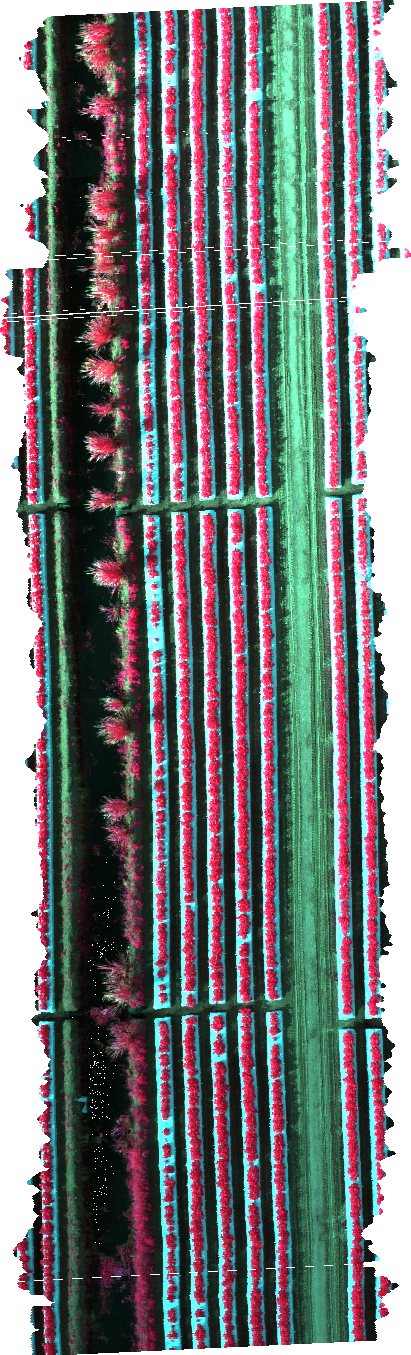

In [11]:
# Color Infrared Image Composite
arcpy.Render(r, {'bands': [4, 1, 2]})

### Calculate Spectral Index: NDVI

Learn more about NDVI here: https://pro.arcgis.com/en/pro-app/latest/help/analysis/raster-functions/ndvi-function.htm

In [12]:
# Unpack individual spectral channels
red, green, blue, nir = r.getRasterBands()

In [13]:
def calculate_vegetation_index(nir_band, red_band):
    '''Calculates the Normalized Difference Vegetation Index (NDVI) and
    outputs values from -1.0 to 1.0 used to quantify vegetation greenness
    for understanding its density and health'''

    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return ndvi

In [14]:
ndvi = calculate_vegetation_index(nir, red)

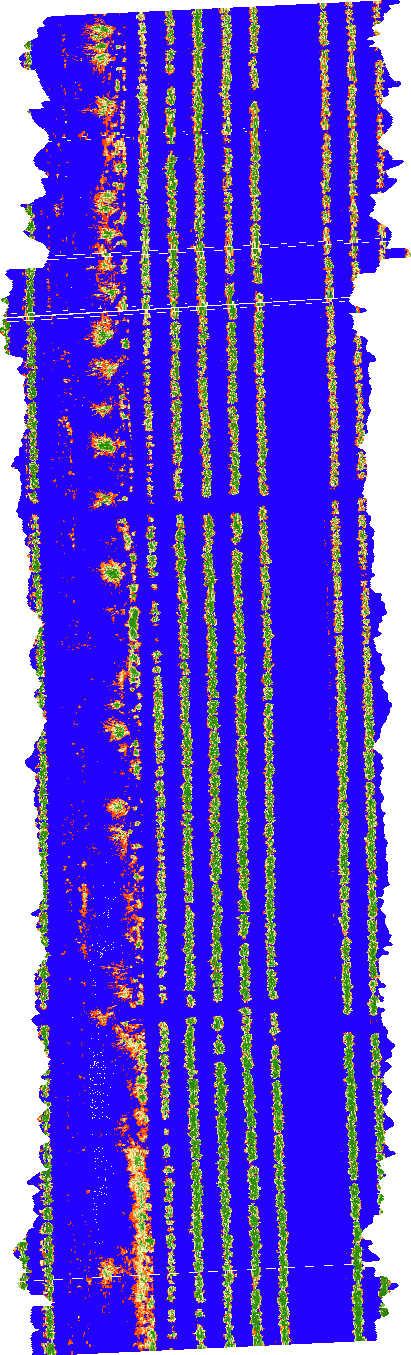

In [15]:
# Plot result and apply color ramp to stretch pixel values from specified min to max
arcpy.Render(ndvi, {'min': 0.2, 'max': 1}, colormap='NDVI3')

In [16]:
# Write file to disk
arcpy.management.CopyRaster(ndvi, 'ndvi_data_product.tif')

<Result 'C:\\Users\\thindle2016\\OneDrive - Liberty University\\geog650\\github\\geog650-gis-programming\\mod5-image-processing-and-analysis\\data\\ndvi_data_product.tif'>

### Threshold Pixel Values to Extract a Feature Mask

In [17]:
# Minimum value
ndvi.minimum

-0.931034505367279

In [18]:
# Maximum value
ndvi.maximum

0.8451613187789917

In [19]:
# Threshold for (non-)vegetation
threshold = 0.2

In [20]:
# Binary feature extraction of (non-)vegetation
# Apply conditional expression to evaluate as False (0) background and True (1) vegetation
vegetation_mask = ((ndvi > threshold) & (ndvi < ndvi.maximum))

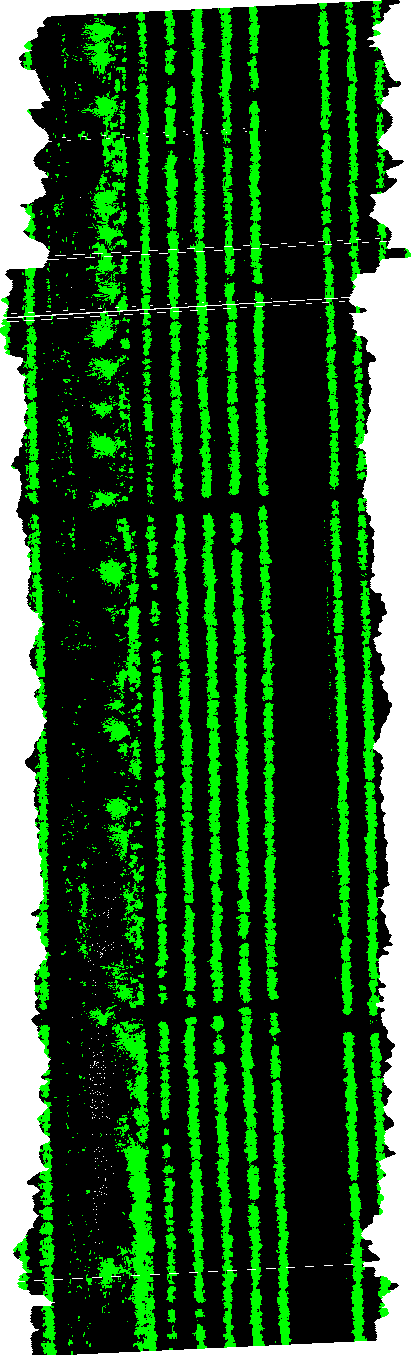

In [21]:
# Plot result where pixel values are False (0) background and True (1) vegetation
arcpy.Render(vegetation_mask, colormap={'values': [0, 1], 'colors': ['black', 'green']})